I misunderstood the definitions of Enrichment vs ROC and AUC vs LogAUC. 

This notebook is to explain both the definitions of these terms as well as re-analyze the prior data. 

We are going to start with a deduplicated strain dataset. This isn't ideal data because of how we deduplicated. We unfortunately need to re-dock the original dataset in a better way. 

Let's load the data and just do the basic explanation for now. 

In [82]:
import pickle
import pandas as pd

def load_from_pickle(filename):
    with open(filename, "rb") as f:
        df = pickle.load(f)
    return df

data = load_from_pickle("all_data_subset_dedup.pkl")

Enrichment and Enrichment AUC are distinct from ROC and ROC-AUC/LogAUC. 

Enrichment in virtual screening is typically done as a rank ordered assessment of how fast you are finding your actives in a docking run. Enrichment can be useful to look at directly, as you can visually assess the steepness of the curve. It is similar to a ROC curve, but ultimately different. 

For enrichment by docking score, you order your dataset from best to worst docking score. Your data should have a 0 and 1 label for the activity status of the compound in the row. You then do a cumulative sum in a new column as you progress though the activity status. So your active with the best docking score has a Cumulative Sum of 1, your second best has a cumulative sum of 2, your third best has a cumulative sum of 3 and so on. Then, you can make another column that is the fractions of actives you've identified, that is the cumulative sum at that row divided by a constant value of your total positives. 

Now, you can divide the index of your docking set by the length of your dataset to get percent (or fraction) you've screened. You can plot the Fraction of Detected Positives (Y) vs Percentage Screened to get a plot like the one below:

In [83]:
import numpy as np

def calculate_enrichment_parameters(df):
    """
    Calculates parameters we will need for Enrichment Plots

    Parameters:
    df (pandas.DataFrame): The dataframe to calculate the logAUC for.

    Returns:
    pandas.DataFrame: The dataframe with the logAUC calculated.
    """
    # Sort the subset by 'r_i_docking_score' in ascending order
    df.sort_values(by="r_i_docking_score", inplace=True)

    # Reset the index so that we are ranking by the docking score
    df.reset_index(drop=True, inplace=True)

    # Adjusting the index to start from 1
    df.index += 1 

    # Calculate the cumulative sum of active compounds
    df["Cumulative_Actives"] = df["Activity"].cumsum()

    # Calculate the Total Actives
    df["Total_Actives"] = df["Activity"].sum()

    # Calculate the fraction of identified actives at each row
    df["Fraction_Actives"] = df["Cumulative_Actives"] / df["Total_Actives"]

    # Calculate the percentage of compounds screened at each row
    df["Percentage_Screened"] = df.index / len(df) 

    return df

In [84]:
calculate_enrichment_parameters(data)

,Molecule_Name,Mol,Activity,r_i_docking_score,Total_E,Lower_Bound,Upper_Bound,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened
1,17509036,<rdkit.Chem.rdchem.Mol object at 0x54569c090>,0,-11.379000,12.383258,10.774766,inf,0,24,0.0,0.000004
2,17407344,<rdkit.Chem.rdchem.Mol object at 0x50dcd0360>,0,-11.056100,10.874642,8.114060,NaN,0,24,0.0,0.000007
3,24784061,<rdkit.Chem.rdchem.Mol object at 0x4f072b290>,0,-10.927400,11.043108,10.040673,NaN,0,24,0.0,0.000011
4,17407000,<rdkit.Chem.rdchem.Mol object at 0x50dcd0450>,0,-10.839600,11.432821,7.485982,NaN,0,24,0.0,0.000015
5,47201060,<rdkit.Chem.rdchem.Mol object at 0x50dcd04f0>,0,-10.655100,5.091219,4.529746,5.913435,0,24,0.0,0.000019
...,...,...,...,...,...,...,...,...,...,...,...
269330,26665106,<rdkit.Chem.rdchem.Mol object at 0x66301ab10>,0,0.588781,0.988140,0.727169,1.279182,24,24,1.0,0.999985
269331,860318,<rdkit.Chem.rdchem.Mol object at 0x663062b60>,0,0.776713,4.875106,4.118975,NaN,24,24,1.0,0.999989
269332,4244719,<rdkit.Chem.rdchem.Mol object at 0x663062bb0>,0,0.866768,6.162786,5.536448,inf,24,24,1.0,0.999993
269333,26663220,<rdkit.Chem.rdchem.Mol object at 0x6619fac00>,0,0.898282,4.117408,3.237282,NaN,24,24,1.0,0.999996


In [85]:
# Find the first row where the Fraction_Actives is equal to 1.0
# Create a boolean mask where each value is True if the corresponding value in 'Fraction_Actives' is 1.0
mask = data['Fraction_Actives'] == 1.0

# Find the index of the first True value in the mask
first_row_index = mask.idxmax()

# Get the entire row at that index
first_row = data.loc[first_row_index]

# Percent where we should reach "1" in the Enrichment plot 
percent = round((first_row_index / len(data) * 100))

print(f"The first row where 'Fraction_Actives' is equal to 1.0 is at index: {first_row_index}.")
print(f"This corresponds to the {percent}% of the data.")
print(f"The entire row at this index is:\n{first_row}")

The first row where 'Fraction_Actives' is equal to 1.0 is at index: 266443.
This corresponds to the 99% of the data.
The entire row at this index is:
Molecule_Name                                               24810675
Mol                    <rdkit.Chem.rdchem.Mol object at 0x50dcd02c0>
Activity                                                           1
r_i_docking_score                                           -4.31976
Total_E                                                     9.300247
Lower_Bound                                                 7.608795
Upper_Bound                                                      NaN
Cumulative_Actives                                                24
Total_Actives                                                     24
Fraction_Actives                                                 1.0
Percentage_Screened                                         0.989266
Name: 266443, dtype: object


In [86]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import auc

matplotlib.rcdefaults()
plt.style.use("seaborn-darkgrid")
plt.rcParams["figure.dpi"] = 144


def plot_enrichment_curve(df):
    """
    Plots the enrichment curve for a dataframe.

    Parameters:
    df (pandas.DataFrame): The dataframe to plot the enrichment curve for.
    enrichment_auc (float): The area under the curve for the enrichment.

    Returns:
    None
    """
    enrichment_auc = auc(df["Percentage_Screened"], df["Fraction_Actives"])

    plt.plot(
        df["Percentage_Screened"] * 100,
        df["Fraction_Actives"],
        label="Enrichment AUC = {:.2f}".format(enrichment_auc),
    )

    # Add axis labels and title
    plt.xlabel("Compounds Screened (%)")
    plt.ylabel("Fraction of Identified Actives")
    plt.title("Enrichment Curve")

    plt.legend()
    plt.show()

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_45853/3990542446.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


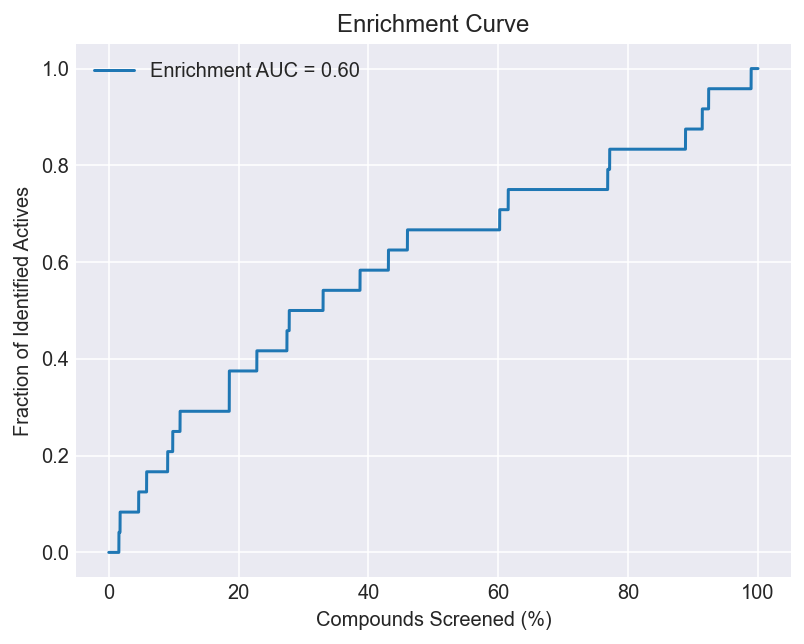

In [87]:
plot_enrichment_curve(data)

Personally, I think the Enrichment Curve is a good visual way to represent the performance of some screening method. However, what can be deceptive is the reporting of AUC values. We tend to value early enrichment more than total enrichment. That is typically where concepts like 'LogAUC' come in, because it changes the scaling of the X axis, we'll get into that in more detail later. Additionally, people do use Enrichment style metrics more commonly as a function of where in the library they are evaluated, such as enrichment at top 1% of scores or something like that. 

See this quote from Irwin et al in '[Enrichment Score: a better quantitative metric for evaluating the enrichment capacity of molecular docking models](https://arxiv.org/pdf/2210.10905.pdf)'.

> For example, the metric known as enrichment factor (EF) captures the idea of enrichment by equating it to the proportion of actives present in some top fraction of best scoring molecules[15]. Quantitative metrics like EF also allow researchers to compare the performance of different docking models on the same dataset of actives and decoys[16].

Before we can discuss LogAUC (as I am not sure if it applied to Enrichment Curves or not), let's discuss ROC Characteristc: Reciever Operator Characteristic Curve. I always get this concept confused in my head so let's put it on paper with virtual screening examples. 

First, let's set up the basics of what a ROC Curve is: it is a visual method of assessing the predicitive capabilities of a classification model that is driven by some function. It is an 2D X,Y plot that looks like this: 

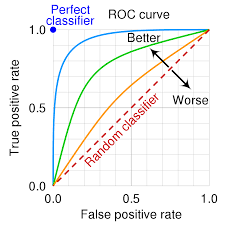

The True Positive Rate (TPR), also known as sensitivity or recall, is calculated as:

$$ TPR = \frac{TP}{TP + FN} $$

where:
- $TP$ is the number of true positives
- $FN$ is the number of false negatives

The False Positive Rate (FPR), also known as fall-out, is calculated as:

$$ FPR = \frac{FP}{FP + TN} $$

where:
- $FP$ is the number of false positives
- $TN$ is the number of true negatives

What the ROC curve is showing you, at each point on the curve is the predictive power of a classifier at a given *threshold*. The curve is like a summarized version of these thresholds. 

Let's use our docking data to explain the situation with examples. We are using a docking score to classify molecules as active or inactive. We hypothesize that molecules below some score are active, then we have a labeled dataset where we know the actual truth, which allows us to find our number of true/false positive/negatives. 

Let's imagine we use -7 as our first cut off, anything <7 will be labeled active. 



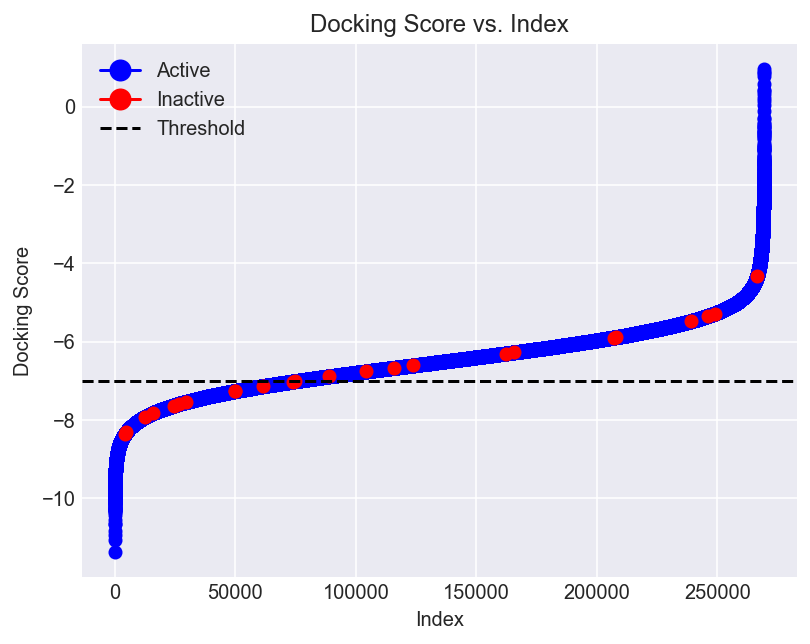

In [88]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Create a scatter plot of 'r_i_docking_score' vs. the index

# Plot points with Activity = 0
plt.scatter(data[data['Activity'] == 0].index, 
            data[data['Activity'] == 0]['r_i_docking_score'], 
            c='blue', 
            label='Activity = 0')

# Plot points with Activity = 1
plt.scatter(data[data['Activity'] == 1].index, 
            data[data['Activity'] == 1]['r_i_docking_score'], 
            c='red', 
            label='Activity = 1')

# Add a horizontal line at -7
plt.axhline(y=-7, color='black', linestyle='--')

# Create a custom legend
blue_line = mlines.Line2D([], [], color='blue', marker='o', markersize=10, label='Active')
red_line = mlines.Line2D([], [], color='red', marker='o', markersize=10, label='Inactive')
black_line = mlines.Line2D([], [], color='black', linestyle='--', label='Threshold')

plt.legend(handles=[blue_line, red_line, black_line])

# Add title and labels
plt.title('Docking Score vs. Index')
plt.xlabel('Index')
plt.ylabel('Docking Score')

# Show the plot
plt.show()

Now, let's look at how this threshold performed as true/false positive/negative.

In [89]:
from sklearn.metrics import confusion_matrix

def calculate_confusion_matrix(df, cutoff):
    # Create a copy of the DataFrame to avoid modifying the original one
    data_copy = df.copy()

    # Create a new column 'predicted_activity' in the DataFrame
    # If 'r_i_docking_score' is less than the cutoff, 'predicted_activity' is 1, otherwise it's 0
    data_copy['predicted_activity'] = (data_copy['r_i_docking_score'] < cutoff).astype(int)

    # Calculate the confusion matrix
    cm = confusion_matrix(data_copy['Activity'], data_copy['predicted_activity'])

    # Convert the confusion matrix to a DataFrame and add labels
    cm_df = pd.DataFrame(cm, 
                         index=['True Negative', 'True Positive'], 
                         columns=['Predicted Negative', 'Predicted Positive'])

    # Return the labeled confusion matrix
    return cm_df

In [90]:
cm_7 = calculate_confusion_matrix(data, -7)
cm_7

,Predicted Negative,Predicted Positive
True Negative,193678,75632
True Positive,12,12


We can plot a point on our ROC Curve from this by calculating the TPR and FPR:

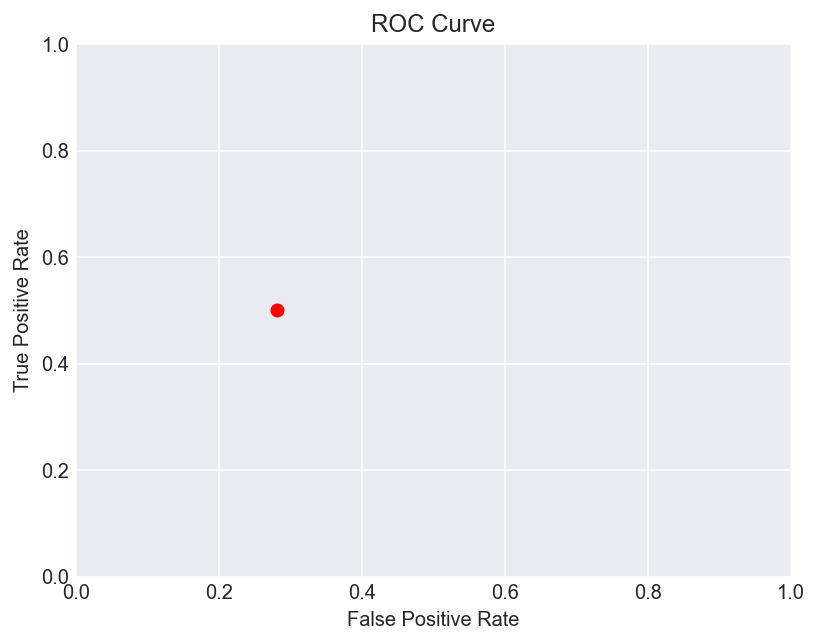

In [91]:
def plot_roc_point(cm_df):
    # Calculate TPR and FPR
    TPR = cm_df.loc['True Positive', 'Predicted Positive'] / (cm_df.loc['True Positive', 'Predicted Positive'] + cm_df.loc['True Positive', 'Predicted Negative'])
    FPR = cm_df.loc['True Negative', 'Predicted Positive'] / (cm_df.loc['True Negative', 'Predicted Positive'] + cm_df.loc['True Negative', 'Predicted Negative'])

    # Create a scatter plot with the TPR and FPR
    plt.scatter(FPR, TPR, color='red')

    # Set the x and y axis limits
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    # Add labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

    # Show the plot
    plt.show()

plot_roc_point(cm_7)

You can imagine now that we could repeat this process for any threshold we want. If we use everything better than the worst docking score, we will get to point (1,1) if we use anything better than the best docking docking score, we will get (0, 0).  

All the sensible values of our threshold (those in the data), can be used to generate all the points for the curve. We only need to take enough to get a good curve. 

Let's now get the ROC Curve for our docking data. 

In [92]:
import numpy as np
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(df, num_thresholds=100):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import auc

    # Generate a set number of evenly spaced thresholds between the minimum and maximum 'r_i_docking_score' values
    thresholds = np.linspace(df['r_i_docking_score'].min(), df['r_i_docking_score'].max(), num_thresholds)

    # Initialize lists to store the TPRs and FPRs for each threshold
    tprs = []
    fprs = []

    # For each threshold, calculate the confusion matrix and then the TPR and FPR
    for threshold in thresholds:
        cm_df = calculate_confusion_matrix(df, threshold)
        TPR = cm_df.loc['True Positive', 'Predicted Positive'] / (cm_df.loc['True Positive', 'Predicted Positive'] + cm_df.loc['True Positive', 'Predicted Negative'])
        FPR = cm_df.loc['True Negative', 'Predicted Positive'] / (cm_df.loc['True Negative', 'Predicted Positive'] + cm_df.loc['True Negative', 'Predicted Negative'])
        tprs.append(TPR)
        fprs.append(FPR)

    # Plot the ROC curve
    plt.plot(fprs, tprs, color='blue', label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')  # Add a diagonal line
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    # Calculate the Area Under the Curve (AUC)
    auc_value = auc(fprs, tprs)
    print('AUC:', auc_value)

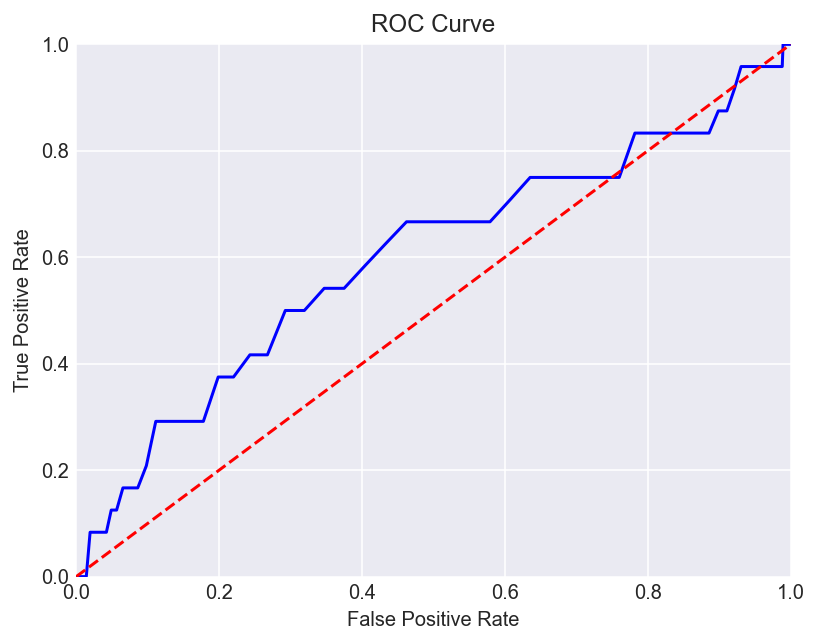

AUC: 0.5966922412832795


In [93]:
plot_roc_curve(data, num_thresholds=200)

Typically, the AUC (or area under the curve) of the ROC is used in classification problems to describe the performance of your model, you can see it below the graph. However, that can be deceptive. As our model continues to gather false positives (labeling compounds as active when they're not, practically "what you would want to buy/ visually inspect), we become practically buried in the data. What we *want* is immediate enrichment. One way people have tried to accomplish this is by 'LogAUC'. 

I find it easier to quote the authors of the previous paper as it is very well written. Briefly, before we can get to LogAUC, we have to introduce a plot we haven't made yet - the linear log plot.

> We consider the plot of f with the x-axis on a logarithmic scale and the y-axis unchanged (on a linear scale). This kind of plot is known as a **linear-log plot**. This logarithmic scaling of the x-axis is used in order to preferentially weight the early behavior of the function in determining the total value of LogAUC. In this way, LogAUC uses the well-understood mathematical operation of the logarithm to formalize the idea that earlier enrichment is significantly more important than later enrichment; in fact, because the logarithm is the inverse operation of exponentiation, the choice to use logarithmic scaling implies that earlier enrichment is, in particular, *exponentially* more important than later enrichment.

In short, a linear log plot has a transformed x-axis that this logarthimic. 

LogAUC (as I understand it), is, counterintuitively, ***not*** just the integral (or area under the curve) of the linear log plot. Rather, it is that area, divided by the performance of a perfect classifier. 

To confirm, they re-iterate this later when describing their alternative metric: 

> On that note, it should be remembered that LogAUC itself is also not simply the log-scaled area under the curve (as is shown in Equation 2):

The authors define LogAUC like this, where f is A(f;a) is presumably the AUC (A) of the linear log plot of your docking score (f) and a parameter (a) which I will discuss more later:

$$ LogAUC(f; a) = \frac{A(f; a)}{A(1; a)} $$

The 'a' term essentially comes up because we need take the integral from 0 to 1 (the FPR rate in the ROC plot) in the linear log plot to get an AUC, so ln(0) -> ln(1), but a ln(x) at x = 0 is undefined. So instead, a value of 'a' that is arbitraily close to zero is used instead. 

> According to the literature [13, 9, 10, 19, 21], there is the standard offset value a = 1.0 × 10−3 that is typically used by practitioners who employ LogAUC to evaluate the enrichment capacity of their docking models.

The paper goes through their rhetoric of why this is a bad idea. Truthfully, I find the math notation difficult to follow. Intuitively, we have already described how to get a ROC plot. We evaluate the confusion matrix at sufficient large amount of thresholds/cutoffs to compute a satisfactory curve. It is relatively intuitive to imagine the x axis being logarthimically scaled. It is relatively intuive to imagine the integral across linear-log plot. What I can't intuit is how the value of a changes this. It is equation 4 where I don't follow anymore.  

Ultimately they argue that because of these equations, y1 (the first true positive, I assume by rank order?) can be become to large if a is set too low (starting the integral earlier) or if it is too high, some molecules are discarded (?). 

They continue to argue that therefor, 'a' shouldn't be the constant most people use. However, you need a constant 'a' to compare LogAUC between two sources. They solve this by standardizing 'a' in their EnrichmentScore. We will cover this later. As we first want to just get a basic LogAUC going.

So first, we need to transform the [0,1] x axis to [log(a),log(1)]. If we use a = 10E-3, we are between [-2, 0]. In the figures you can see the graphs go from 10E-3 and 10^0 (1).

I think the semilog(x) version is best (it's a little confusing how to do this)

In [106]:
def plot_linlog_roc_curve(df, num_thresholds=100, a=1e-3):
    # Generate a set number of evenly spaced thresholds between the minimum and maximum 'r_i_docking_score' values
    thresholds = np.linspace(
        df["r_i_docking_score"].min(), df["r_i_docking_score"].max(), num_thresholds
    )

    # Initialize lists to store the TPRs and FPRs for each threshold
    tprs = []
    fprs = []

    # For each threshold, calculate the confusion matrix and then the TPR and FPR
    for threshold in thresholds:
        cm_df = calculate_confusion_matrix(df, threshold)
        TPR = cm_df.loc["True Positive", "Predicted Positive"] / (
            cm_df.loc["True Positive", "Predicted Positive"]
            + cm_df.loc["True Positive", "Predicted Negative"]
        )
        FPR = cm_df.loc["True Negative", "Predicted Positive"] / (
            cm_df.loc["True Negative", "Predicted Positive"]
            + cm_df.loc["True Negative", "Predicted Negative"]
        )
        if FPR >= a:  # FPR must be greater than or equal to a to plot on a log scale
            tprs.append(TPR)
            fprs.append(FPR)  # Append the FPR to the list

    # Plot the ROC curve
    plt.semilogx(fprs, tprs, color="blue", label="ROC Curve")
    plt.xlim([a, 1])
    plt.ylim([0, 1])
    plt.xlabel("Log (False Positive Rate)")
    plt.ylabel("True Positive Rate")
    plt.title(" Linear Log ROC Curve")
    plt.show()

    # Calculate the Area Under the Curve (AUC)
    print(f"(FPR >= {a})")
    linlog_auc = auc(fprs, tprs)
    print("AUC of Linear Log Plot:", linlog_auc)
    log_auc = linlog_auc / -np.log10(a)
    print(f"Log AUC Plot by diving AUC by -log(a):", log_auc)

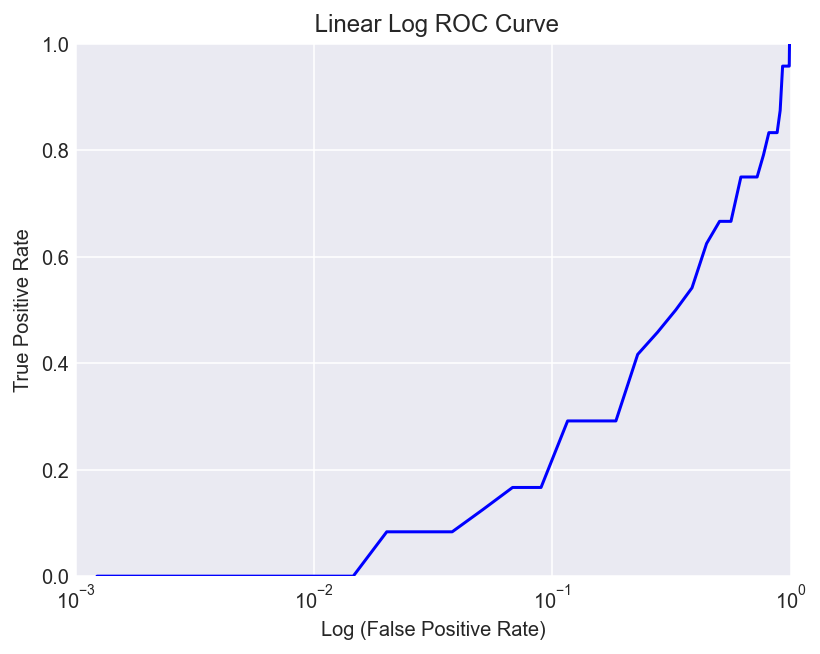

(FPR >= 0.001)
AUC of Linear Log Plot: 0.5953014957979033
Log AUC Plot by diving AUC by -log(a): 0.19843383193263442


In [107]:
plot_linlog_roc_curve(data, num_thresholds=100, a=1e-3)

In [96]:
import numpy as np
import matplotlib.pyplot as plt


def plot_linlog_roc_curve(df, num_thresholds=100, a=1e-3):
    # Generate a set number of evenly spaced thresholds between the minimum and maximum 'r_i_docking_score' values
    thresholds = np.linspace(
        df["r_i_docking_score"].min(), df["r_i_docking_score"].max(), num_thresholds
    )

    # Initialize lists to store the TPRs and FPRs for each threshold
    tprs = []
    fprs = []

    # For each threshold, calculate the confusion matrix and then the TPR and FPR
    for threshold in thresholds:
        cm_df = calculate_confusion_matrix(
            df, threshold
        )  # You need to define the calculate_confusion_matrix function
        TPR = cm_df.loc["True Positive", "Predicted Positive"] / (
            cm_df.loc["True Positive", "Predicted Positive"]
            + cm_df.loc["True Positive", "Predicted Negative"]
        )
        FPR = cm_df.loc["True Negative", "Predicted Positive"] / (
            cm_df.loc["True Negative", "Predicted Positive"]
            + cm_df.loc["True Negative", "Predicted Negative"]
        )
        if FPR >= a:  # FPR must be greater than or equal to 'a' to plot on a log scale
            log_FPR = np.log10(FPR)  # Calculate the logarithm of the FPR
            tprs.append(TPR)
            fprs.append(log_FPR)  # Append the logarithm of the FPR to the list

    # Plot the ROC curve
    plt.plot(fprs, tprs, color="blue", label="ROC Curve")

    plt.xlim([np.log10(a), 0])
    plt.ylim([0, 1])
    plt.xlabel("Log (False Positive Rate)")
    plt.ylabel("True Positive Rate")
    plt.title("Linear Log ROC Curve")
    plt.show()

    # Calculate the Area Under the Curve (AUC)
    print(f"(FPR >= {a})")
    linlog_auc = auc(fprs, tprs)  # You need to import and define the 'auc' function
    print("AUC of Linear Log Plot:", linlog_auc)

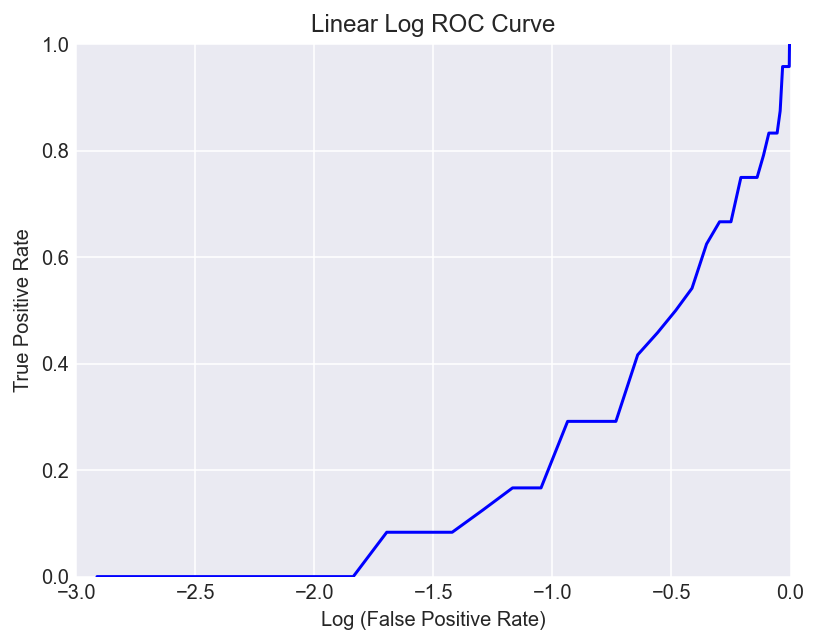

(FPR >= 0.001)
AUC of Linear Log Plot: 0.6099026510081699


In [97]:
plot_linlog_roc_curve(data, a=1e-3, num_thresholds=100)

Now I need to find the auc of a perfect classifier at this space but I don't understand how to do that? The paper says = Amax = A(f = 1; a) = − ln(a). So I used that for now. 

This seems to be the basics of Enrichment, ROC, and "LogAUC". We could implement their Enrichment Score, but it would be good to have code to work with. 

Side Point: Francesco and I were discussing Enrichment vs ROC. I wanted to check some things.

To the previous analysis, can you gauge how many compounds you've screened in a ROC curve? What if we only plot a few threshold values with our previous function. 

In [98]:
def calculate_confusion_matrices(df, cutoffs):
    # Initialize a dictionary to store the confusion matrices
    confusion_matrices = {}

    # For each cutoff, calculate the confusion matrix and add it to the dictionary
    for cutoff in cutoffs:
        cm_df = calculate_confusion_matrix(df, cutoff)
        confusion_matrices[cutoff] = cm_df

    # Return the dictionary of confusion matrices
    return confusion_matrices

In [99]:
cutoffs_val = [-9, -8, -7, -6, -5]
confusion_matrices_dict = calculate_confusion_matrices(data, cutoffs_val)
confusion_matrices_dict

{-9:                Predicted Negative  Predicted Positive
 True Negative              268607                 703
 True Positive                  24                   0,
 -8:                Predicted Negative  Predicted Positive
 True Negative              258862               10448
 True Positive                  22                   2,
 -7:                Predicted Negative  Predicted Positive
 True Negative              193678               75632
 True Positive                  12                  12,
 -6:                Predicted Negative  Predicted Positive
 True Negative               73078              196232
 True Positive                   6                  18,
 -5:                Predicted Negative  Predicted Positive
 True Negative               11250              258060
 True Positive                   1                  23}

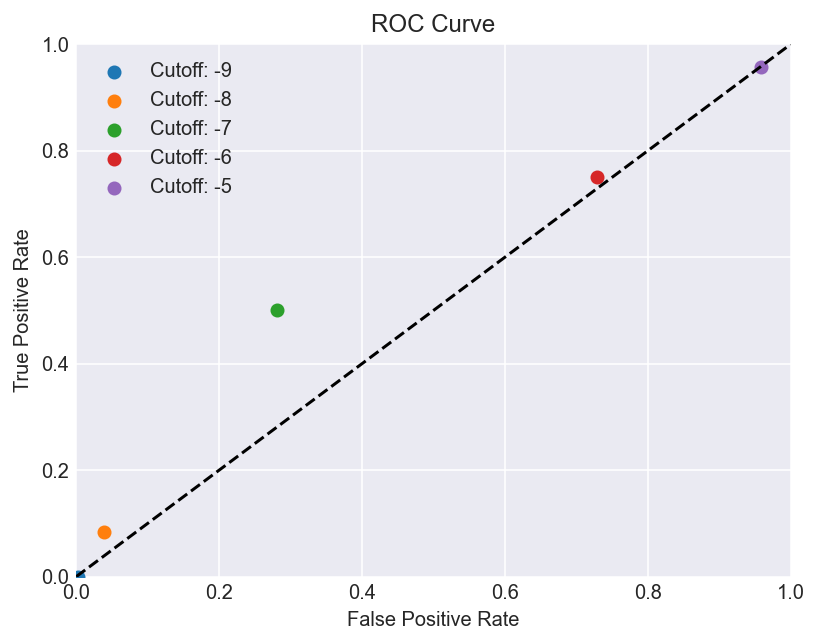

In [100]:
def plot_roc_points(confusion_matrices):
    # Initialize the plot
    plt.figure()

    # For each cutoff, calculate the TPR and FPR and plot them
    for cutoff, cm_df in confusion_matrices.items():
        TPR = cm_df.loc['True Positive', 'Predicted Positive'] / (cm_df.loc['True Positive', 'Predicted Positive'] + cm_df.loc['True Positive', 'Predicted Negative'])
        FPR = cm_df.loc['True Negative', 'Predicted Positive'] / (cm_df.loc['True Negative', 'Predicted Positive'] + cm_df.loc['True Negative', 'Predicted Negative'])
        plt.scatter(FPR, TPR, label=f'Cutoff: {cutoff}')

    # Add a diagonal line
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')

    # Set the x and y axis limits
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    # Add labels, title, and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Show the plot
    plt.show()

# Calculate the confusion matrices for the cutoffs
confusion_matrices = calculate_confusion_matrices(data, cutoffs_val)

# Plot the ROC points
plot_roc_points(confusion_matrices)

In [101]:
def find_rows(data, values):
    for value in values:
        row = data.loc[
            (data["r_i_docking_score"] >= value - 0.1) & (data["r_i_docking_score"] <= value + 0.1)
        ].iloc[0]
        print(row)

# Call the function with a list of values
find_rows(data, cutoffs_val)

Molecule_Name                                               24841535
Mol                    <rdkit.Chem.rdchem.Mol object at 0x50dcd2de0>
Activity                                                           0
r_i_docking_score                                           -9.09971
Total_E                                                    10.374649
Lower_Bound                                                 8.692498
Upper_Bound                                                      inf
Cumulative_Actives                                                 0
Total_Actives                                                     24
Fraction_Actives                                                 0.0
Percentage_Screened                                         0.001972
Name: 531, dtype: object
Molecule_Name                                                 860198
Mol                    <rdkit.Chem.rdchem.Mol object at 0x58dc7d260>
Activity                                                           0
r_i_docki